# Classification of power spectra with BaCoN

This notebook shows how to classify a dark matter PS using the pre-trained BaCoN. It can be used to classify any new spectrum. See the data description for the format required

## Load the code
 
Here we mount the drive and import BaCoN. If running on your machine, be sure to have tensorflow2 and tensorflow probability installed and jump directly to the imports. 

In [43]:
from utils import *
from testt import *
from models import *
from data_generator import *
from train import *

In [44]:
from testt import load_model_for_test

In [45]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'serif'
plt.rcParams["mathtext.fontset"] = "cm"

In [46]:
%ls data/

example_spectra/  planck.txt*  test_data/  train_data/


## Functions to load models and data

In [47]:
def read_pre_trained_flags(args_dict):
  '''
  Read model options from logfile and return them in the form of FLAGS (the corresponding class is in utils)
  '''
  args = DummyFlags(args_dict)
  FLAGS = get_flags(args.log_path)
  if args.models_dir is not None:
        print('Reading model from the directory %s' %args.models_dir)
        FLAGS.models_dir = args.models_dir
  return FLAGS


def get_pre_trained_model(fname, n_classes, input_shape):
  '''
  returns pre-trained model.
  Input:  - fname: string, folder where the trained model is stored
          - n_classes: integer, number of output classes of the model
          - input_shape:  tuple, input dimensions of the model.
                          For pre-trained model in the paper use (100, 4)
  
  '''

  log_path = os.path.join('models', fname, fname+'_log.txt' )
  models_dir = os.path.join('models', fname)

  args_dict= {'log_path':log_path, 'models_dir': models_dir, }
  FLAGS=read_pre_trained_flags(args_dict)

  print('Input shape %s' %str(input_shape))


  model_loaded =  load_model_for_test(FLAGS, input_shape, n_classes=n_classes,
                                        generator=None, new_fname='') 


  return model_loaded



def load_X(fname, sample_pace, i_max, norm_data, 
           add_noise=True, normalise=True, use_sample_pace=False, include_k=True):
  '''
  Generates one power spectrum X ready for classification.
  Options:  fname: path to data
            sample_pace: read one point every sample_pace. Useful to reduce data dimension
            i_max: Index corresponding to the max k used
            norm_data: normalization spectrum

            add_noise: whether to add noise or not
            normalise: normalise by Planck or not
            use_sample_pace
            include_k: return k, X or only X


  
  '''
  
  all = np.loadtxt(fname)
  print('loaded data shape: %s' %str(all.shape))
  if include_k:
    k, X = all[:, 0], all[:, 1:]
    print('k, X  shape: %s, %s' %(str(k.shape), str(X.shape)))
  else:
    X = all
    k=np.arange(X.shape[0])
    print('X  shape : %s' %( str(X.shape)))
  if use_sample_pace:
    k, X = k[::sample_pace], X[::sample_pace]
  print('X  shape after sample pace:  %s' %( str(X.shape)))
  k, X  = k[:i_max], X[:i_max]
  print('X  shape after k max: %s' %( str(X.shape)))
  if add_noise:
    noise = np.random.normal(loc=0, scale=generate_noise(k,X, add_sys=True,add_shot=True,sigma_sys=5 ))
    X = X+noise
  if normalise:
    planck = norm_data
    print('planck data shape: %s' %str(planck.shape))
    X = X/planck-1
  if include_k:
    return k, X
  else:
    return X

In [48]:
# Encoding of the labels for the two networks. Can be found in the log file of the training. 
# Here it is easier to define it by hand.

inv_labels_dict_5={0:'dgp', 1:'fR', 2:'lcdm', 3:'rand', 4:'wcdm'}
inv_labels_dict_2={0:'lcdm', 1:'non-LCDM'}

## Code for getting confidence

In [49]:
def sample_from_data(model,  my_Xs_norm,  my_min=np.zeros(5), my_max=np.ones(5), 
                     n_samples=50000, num_monte_carlo=100, th_prob=0.5,
                     verbose=True):
  '''
  Given some normalized features my_Xs_norm and the model, compute mu and Sigma as in the paper eq. 2.8-2.9
  and return samples from the probability distribuion eq. 2.10
  '''
  Al_error, Ep_error, mean = get_mu_Sigma(model, my_Xs_norm , num_monte_carlo=num_monte_carlo, th_prob=th_prob, verbose=verbose)
  Sigma = (Al_error+ Ep_error).numpy()
  MM = mean.numpy()
  if verbose:
    print('Sigma')
    print(np.round(Sigma, 3))
  samples, z_samples = sample_probas(Sigma, MM, my_min=my_min,my_max=my_max, n_samples=n_samples, verbose=verbose)

  return samples, z_samples, Sigma, MM



def get_mu_Sigma(model, my_Xs_norm, num_monte_carlo=100, th_prob=0.5, verbose=True):
  ''''
  Given some normalized features my_Xs_norm and the model, compute mu and Sigma as in the paper eq. 2.8-2.9
  '''
  if verbose:
    print('Computing mu and sigma...')
  sampled_probas, _, _ = my_predict(tf.expand_dims(my_Xs_norm, axis=0), model, num_monte_carlo=num_monte_carlo, th_prob=th_prob)
  mean = tf.reduce_mean(sampled_probas[:,0,:], axis=0)
  _, Al_error, Ep_error = get_err_variances(sampled_probas[:,0,:])
  return Al_error, Ep_error, mean


def sample_probas(Sigma, MM, my_min=np.zeros(5), my_max=np.ones(5), n_samples=50000, verbose=True):
  '''
  Given mu and Sigma as in the paper eq. 2.8-2.9, computes B, U as described in appendix B of the paper.
  Then calls function to sample the prob. distribution (eq. 2.10)
  '''
  if verbose:
    print('Sample probas call')
  evals, evecs = np.linalg.eig(Sigma)
  B = evecs
  U = B.T @ Sigma @  B
  if verbose:
    print('U')
    print(np.round(U, 3))
  n_dims=U.shape[0]-1
  n_dims=U.shape[0]-1
  ind_min = np.argmin(np.diag(U))
  if verbose:
    print('Index of min eigenvalue is: %s' %ind_min)
    print('Min eigenvalue is: %s' %np.min(np.diag(U)))
  UU = np.array([np.sqrt(U[i,i])  for i in range(U.shape[0]) if i!=ind_min ] )  
  if verbose:
    print('U has %s elements ' %str(UU.shape[0]))
  samples, z_samples = get_samples(UU, B, MM, my_min=my_min, my_max=my_max, ind_min=ind_min, n_dims=n_dims, n_samples=n_samples, verbose=verbose)
  return samples, z_samples


def get_samples(UU, B, MM, my_min=np.zeros(5), my_max=np.ones(5), ind_min=-1, n_dims=4, n_samples=50000, verbose=True):
  '''
  samples eq. 2.10 as described in appendix B
  '''
  if verbose:
    print('Sampling...')
  samples = np.zeros((0, n_dims+1))
  z_samples = np.zeros((0, n_dims)) 
  while samples.shape[0] < n_samples: 
    s = np.random.multivariate_normal( np.zeros(n_dims), np.diag(UU**2), size=(n_samples,))
    accepted = s[(np.min(X_val_batch(s, B, MM, null_ind=ind_min)-my_min, axis=1) >= 0) & (np.max(X_val_batch(s, B, MM, null_ind=ind_min) - my_max, axis=1) <= 0)]
    samples = np.concatenate((samples, X_val_batch(accepted, B, MM, null_ind=ind_min)), axis=0)
    z_samples = np.concatenate((z_samples, accepted), axis=0)
  samples = samples[:n_samples, :]
  z_samples = z_samples[:n_samples, :]
  if verbose:
    print('Done.')
  return samples, z_samples



def X_val_batch(Z, B, MM, null_ind):
  return np.array([ X_val(Z[i], B, MM, null_ind=null_ind,) for i in range(Z.shape[0])])

def Z(X, B, MM):
  '''  X must be 5-d '''
  return B.T @ (X-MM)

def X_val(Z, B, MM, null_ind=-1, verbose=False):
  '''  Z must be 4-d , MM must be 5-d '''
  if verbose:
    print(Z)
  Z = np.insert(Z, null_ind, 0)
  if verbose:
    print(Z)
  return B @ Z+ MM


def get_err_variances(prob_k, AlEp_split=True):
  '''
  Computes aleatoric and epistemic uncertainty from MC samples from the net. weights
  '''
  num_samples = prob_k.shape[0]
  prob_mean = tf.reduce_mean(prob_k, axis=0)

  diag_probs = tf.stack([np.diag(prob_k[i,:]) for i in range(num_samples)], axis=0)  # Diagonal matrix whose diagonal elements are the output of the network for the ith sample
  outer_products_Al = tf.stack([tf.tensordot(prob_k[i,:], prob_k[i,:], axes =0) for i in range(num_samples)], axis=0) # Outer self-product of the predictive vectors for the ith sample used in computing Al uncertainty
  outer_products_Ep = tf.stack([tf.tensordot(prob_k[i,:] - prob_mean, prob_k[i,:] - prob_mean, axes =0) for i in range(num_samples)], axis=0) # Outer self-product between the difference of the predictive vector for ith sampl and average prediction

  Al_error = tf.reduce_mean(diag_probs - outer_products_Al, axis=0) # Average over all the samples to compute aleotoric uncertainty
  Ep_error = tf.reduce_mean(outer_products_Ep, axis=0) # Average over all the samples to compute epistemic uncertainty

  tot_error = Al_error + Ep_error # Combine to compute total uncertainty
  confidences = tf.linalg.diag_part(tot_error).numpy()

  if AlEp_split:
    return confidences, Al_error, Ep_error
  else:
    return confidences



def get_P_from_samples(samples, th_prob=0.5 ):
  '''
  Given samples from eq. 2.10, computes the probabilities as in eq. 2.11
  '''
  Ntot = samples.shape[0] #-unclassified
  n_dims  = samples.shape[-1]
  all_preds = np.array([predict_bayes_label(sample, th_prob=th_prob) for sample in samples])
  unclassified=all_preds[all_preds==99].shape[0]

  n_in_class = np.array([all_preds[all_preds==k].shape[0] for k in range(n_dims)])

  #print('Ntot: %s  ' %Ntot)
  p_uncl=unclassified/Ntot
  #print('%s unclassified examples ' %unclassified)
  #print('P(unclassified)=%s ' %p_uncl)
  pp=n_in_class/Ntot
  #print(pp)
  #print(p_uncl)

  return np.append(pp, p_uncl)


def get_all_probas(X, model_loaded, 
                   n_classes=5, 
                   num_monte_carlo=100,
                   th_prob=0.5, 
                   n_samples=10000, 
                   verbose=True):
    '''
    Given features X, predicts the labels with MC samples from the net, 
    computes mu and sigma, samples from the prob distribution
    and computes P. 
    Returns result in the form of a dictionary 
    '''
    
    # Gaussian approx
    samples, z_samples, Sigma, MM = sample_from_data(model_loaded, 
                                                 my_Xs_norm=X,
                                                 my_min=np.zeros(n_classes), my_max=np.ones(n_classes), 
                                                 n_samples=n_samples, 
                                                 num_monte_carlo=num_monte_carlo,
                                                 th_prob=th_prob, verbose=verbose)
    
    P = get_P_from_samples(samples, th_prob=th_prob)
    if verbose:
      print('P: %s ' %str(P))
      print('P sum to %s' %P.sum())
    if verbose:
      print('mu  sum to %s' %MM.sum())
   
  
    # Result
    res = {'samples':samples, 'P':P, 'z_samples': z_samples, 'Sigma': Sigma, 'MM': MM,}
    return res

In [50]:

def plot_hist_1D(samples, MM, th_prob=0.5,  
                  P=None, inv_labels_dict=None,):
  '''
  Plots histogram of gauss samples for each class
  '''

  n_dims = samples.shape[-1]-1
  fig, axs = plt.subplots(1, n_dims+1, sharey=True, sharex=False,figsize=(25,5))

  t_str=''
  for k in range(n_dims+1):

    axs[k].hist(samples.T[k], bins=15, color = "red",lw=0, density=True, label='Gauss samples')
    axs[k].text(0.1, 0.9, '$\mu = $' + '$'+ str(MM[k])+'$', fontsize = 16 , transform=axs[k].transAxes);
    if P is  not None:
      axs[k].text(0.1, 0.8, '$ P = $' + '$'+ str(P[k])+'$', fontsize = 16 , transform=axs[k].transAxes);  
      if k==0:
        t_str+= 'P unclassified: %s \n' %str(np.round(P[-1], 2) )    
    axs[k].set_xlim(0,1)
    axs[k].set_ylim(0,10)
    
    if inv_labels_dict is not None:
      axs[k].set_title(inv_labels_dict[k])
    
    
    axs[k].legend(loc='lower right')

  axs[0].set_ylabel('P')
  fig.suptitle(t_str)

  plt.show()

In [51]:
import tensorflow as tf
print(tf.__version__)

2.8.2


## Load models 

Here we load the pre trained models 

In [52]:
model_5o = get_pre_trained_model('five_label', 5, (100, 4) )


 -------- Loaded parameters:
bayesian True
test_mode False
n_test_idx 2
seed 1511
fine_tune False
one_vs_all False
c_0 ['lcdm']
c_1 ['dgp', 'fR', 'rand', 'wcdm']
dataset_balanced False
include_last False
log_path 
restore False
fname 2210_MM_1
model_name custom
my_path /content
DIR Train_data_full
TEST_DIR data/test_data/new_test_data
models_dir /content/drive/My Drive/ML_REACT/models/MM/bayes_2/
save_ckpt True
out_path_overwrite False
im_depth 500
im_width 1
im_channels 4
swap_axes True
sort_labels True
normalization stdcosmo
sample_pace 4
k_max 2.5
i_max None
add_noise True
n_noisy_samples 10
add_shot True
add_sys True
sigma_sys 5.0
z_bins [0, 1, 2, 3]
n_dense 1
filters [8, 16, 32]
kernel_sizes [10, 5, 2]
strides [2, 2, 1]
pool_sizes [2, 2, 0]
strides_pooling [2, 1, 0]
add_FT_dense False
trainable False
unfreeze False
lr 0.01
drop 0.5
n_epochs 70
val_size 0.15
test_size 0.0
batch_size 2500
patience 100
GPU True
decay 0.95
BatchNorm True
group_lab_dict {'dgp': 'non_lcdm', 'fR': 'non_

In [53]:
model_5 = get_pre_trained_model('5-label', 5, (100, 4) )


 -------- Loaded parameters:
bayesian True
test_mode False
n_test_idx 2
seed 1312
fine_tune False
one_vs_all False
c_0 ['lcdm']
c_1 ['dgp', 'fR', 'rand', 'wcdm']
dataset_balanced False
include_last False
log_path 
restore False
fname 5-label
model_name custom
my_path None
DIR data/train_data/
TEST_DIR data/test_data/
models_dir models/
save_ckpt True
out_path_overwrite False
im_depth 500
im_width 1
im_channels 4
swap_axes True
sort_labels True
normalization stdcosmo
sample_pace 4
k_max 2.5
i_max None
add_noise True
n_noisy_samples 10
add_shot True
add_sys True
sigma_sys 5.0
z_bins [0, 1, 2, 3]
n_dense 1
filters [8, 16, 32]
kernel_sizes [10, 5, 2]
strides [2, 2, 1]
pool_sizes [2, 2, 0]
strides_pooling [2, 1, 0]
add_FT_dense False
trainable True
unfreeze False
lr 0.01
drop 0.5
n_epochs 40
val_size 0.15
test_size 0.0
batch_size 2500
patience 100
GPU True
decay 0.95
BatchNorm True
group_lab_dict {'dgp': 'non_lcdm', 'fR': 'non_lcdm', 'rand': 'non_lcdm', 'wcdm': 'non_lcdm', 'lcdm': 'lcdm'}


In [54]:
model_2o = get_pre_trained_model('two_label', 2, (100, 4) )

The following line has not been formatted: 
 group_lab_dict {'dgp': 'non_lcdm', 'fR': 'non_lcdm', 'rand': 'non_lcdm', 'wcdm': 'non_lcdm', 'lcdm': 'lcdm'}


 -------- Loaded parameters:
bayesian True
test_mode False
n_test_idx 2
seed 1312
fine_tune False
one_vs_all True
c_0 ['lcdm']
c_1 ['dgp', 'fR', 'rand', 'wcdm']
dataset_balanced False
include_last False
log_path 
restore False
fname 1910_EG_oneVSall_ub
model_name custom
my_path /content
DIR Train_data_full
TEST_DIR data/test_data/new_test_data
models_dir /content/drive/My Drive/ML_REACT/models/MM/bayes_2/
save_ckpt True
out_path_overwrite False
im_depth 500
im_width 1
im_channels 4
swap_axes True
sort_labels True
normalization stdcosmo
sample_pace 4
k_max 2.5
i_max None
add_noise True
n_noisy_samples 10
add_shot True
add_sys True
sigma_sys 5.0
z_bins [0, 1, 2, 3]
n_dense 1
filters [8, 16, 32]
kernel_sizes [10, 5, 2]
strides [2, 2, 1]
pool_sizes [2, 2, 0]
strides_pooling [2, 1, 0]
add_FT_dense False
trainable False
unfreeze False
lr 

In [55]:
model_2 = get_pre_trained_model('2_small', 2, (100, 4) )

The following line has not been formatted: 
 group_lab_dict {'dgp': 'non_lcdm', 'fR': 'non_lcdm', 'rand': 'non_lcdm', 'wcdm': 'non_lcdm', 'lcdm': 'lcdm'}


 -------- Loaded parameters:
bayesian True
test_mode False
n_test_idx 2
seed 1312
fine_tune False
one_vs_all True
c_0 ['lcdm']
c_1 ['dgp', 'fR', 'rand', 'wcdm']
dataset_balanced False
include_last False
log_path 
restore False
fname 2_small
model_name custom
my_path None
DIR data/test_data/
TEST_DIR data/test_data/
models_dir models/
save_ckpt True
out_path_overwrite False
im_depth 500
im_width 1
im_channels 4
swap_axes True
sort_labels True
normalization stdcosmo
sample_pace 4
k_max 2.5
i_max None
add_noise True
n_noisy_samples 10
add_shot True
add_sys True
sigma_sys 5.0
z_bins [0, 1, 2, 3]
n_dense 1
filters [8, 16, 32]
kernel_sizes [10, 5, 2]
strides [2, 2, 1]
pool_sizes [2, 2, 0]
strides_pooling [2, 1, 0]
add_FT_dense False
trainable False
unfreeze False
lr 0.01
drop 0.5
n_epochs 50
val_size 0.15
test_size 0.0
batch_size 2500
pat

## Get data

We provide data used to generate Fig. 6-8 in the paper in the folder example_spectra. Here we show how to load the fR spectrum

Load normalization data first

In [56]:
sample_pace=4 # the planck data were generated with 500 points up to k=10 . We need 1 every 4 points, and to cut to k_max=2.5
i_max=100

planck = np.loadtxt('data/planck.txt')[:, 1:][::sample_pace][:i_max]

In [57]:
planck.shape

(100, 4)

In [58]:
k, X_fR = load_X('/home/master/Desktop/pastırma/BaCoN/data/example_spectra/wcdm_ex.txt', 
                 sample_pace=None, i_max=100, 
                 norm_data=planck,
                 add_noise=False, normalise=True, use_sample_pace=False)

loaded data shape: (100, 5)
k, X  shape: (100,), (100, 4)
X  shape after sample pace:  (100, 4)
X  shape after k max: (100, 4)
planck data shape: (100, 4)


Let's look at the input features as seen by the network.

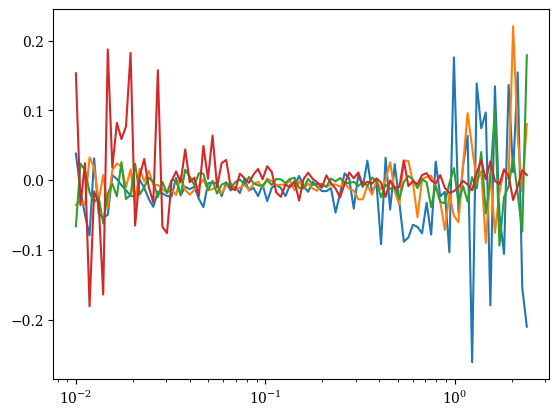

In [59]:
plt.plot(k, X_fR);
plt.xscale('log');

## Classify your spectra and compute confidence

Computing mu and sigma...
Sigma
[[ 0.071 -0.    -0.037 -0.    -0.034]
 [-0.     0.    -0.    -0.    -0.   ]
 [-0.037 -0.     0.25  -0.    -0.212]
 [-0.    -0.    -0.     0.    -0.   ]
 [-0.034 -0.    -0.212 -0.     0.246]]
Sample probas call
U
[[ 0.46  -0.    -0.     0.    -0.   ]
 [ 0.     0.106 -0.     0.    -0.   ]
 [-0.     0.     0.     0.    -0.   ]
 [ 0.    -0.     0.    -0.     0.   ]
 [ 0.    -0.     0.    -0.     0.   ]]
Index of min eigenvalue is: 3
Min eigenvalue is: -5.4742078e-09
U has 4 elements 
Sampling...
Done.
P: [0.049 0.    0.339 0.    0.33  0.282] 
P sum to 1.0
mu  sum to 1.0
P-non-LCDM=0.661


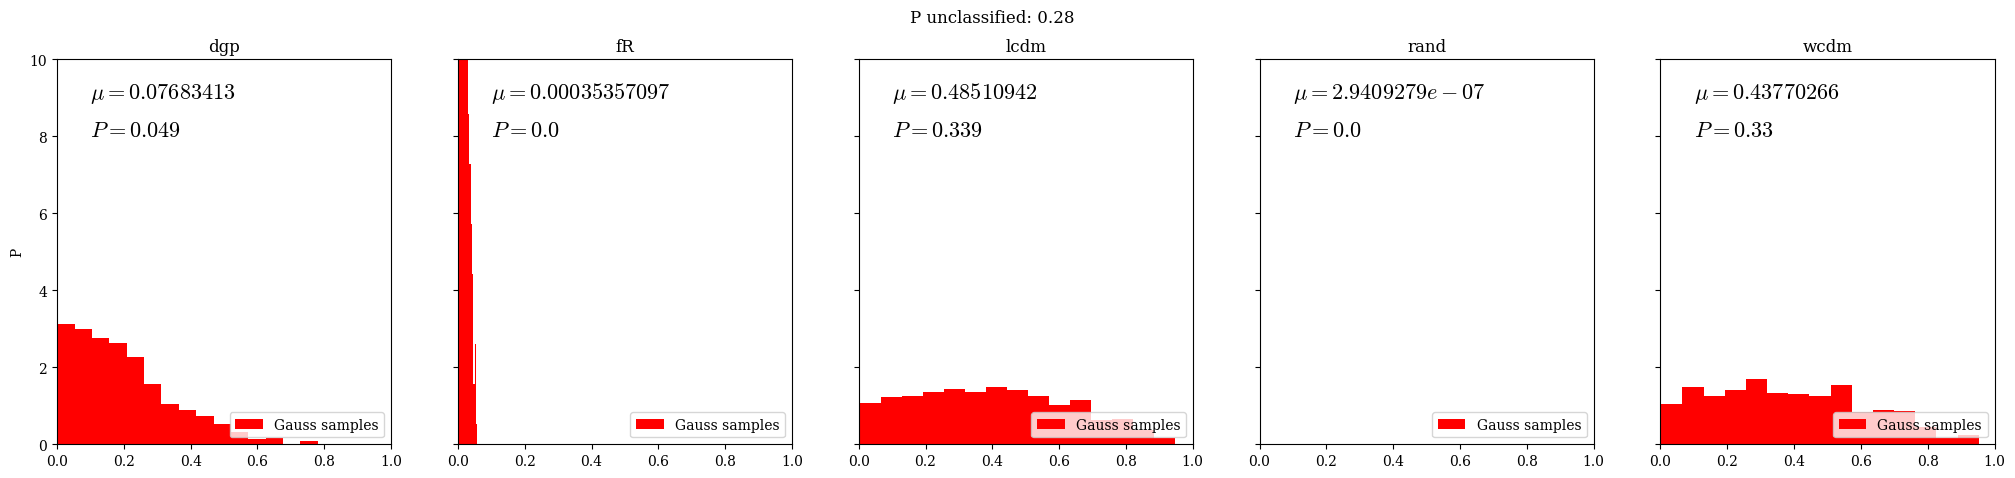

In [60]:
res_fR = get_all_probas(X_fR, 
                        model_5, 
                        n_classes=5, 
                        num_monte_carlo=5, 
                        th_prob=0.5,
                        n_samples=1000)
print('P-non-LCDM=%s' %(np.delete(res_fR['P'], [2]).sum()))
plot_hist_1D(res_fR['samples'], 
             res_fR['MM'],
             th_prob=0.5,  
             P=res_fR['P'], 
             inv_labels_dict=inv_labels_dict_5)

Computing mu and sigma...
Sigma
[[ 0.026 -0.    -0.002 -0.    -0.024]
 [-0.     0.001 -0.    -0.    -0.001]
 [-0.002 -0.     0.054 -0.    -0.053]
 [-0.    -0.    -0.     0.    -0.   ]
 [-0.024 -0.001 -0.053 -0.     0.078]]
Sample probas call
U
[[ 0.124 -0.    -0.     0.     0.   ]
 [-0.     0.034 -0.     0.    -0.   ]
 [-0.    -0.     0.001  0.    -0.   ]
 [-0.    -0.     0.     0.     0.   ]
 [ 0.    -0.    -0.     0.     0.   ]]
Index of min eigenvalue is: 3
Min eigenvalue is: 3.3672218e-09
U has 4 elements 
Sampling...
Done.
P: [0.002 0.    0.042 0.    0.773 0.183] 
P sum to 1.0
mu  sum to 1.0
P-non-LCDM=0.958


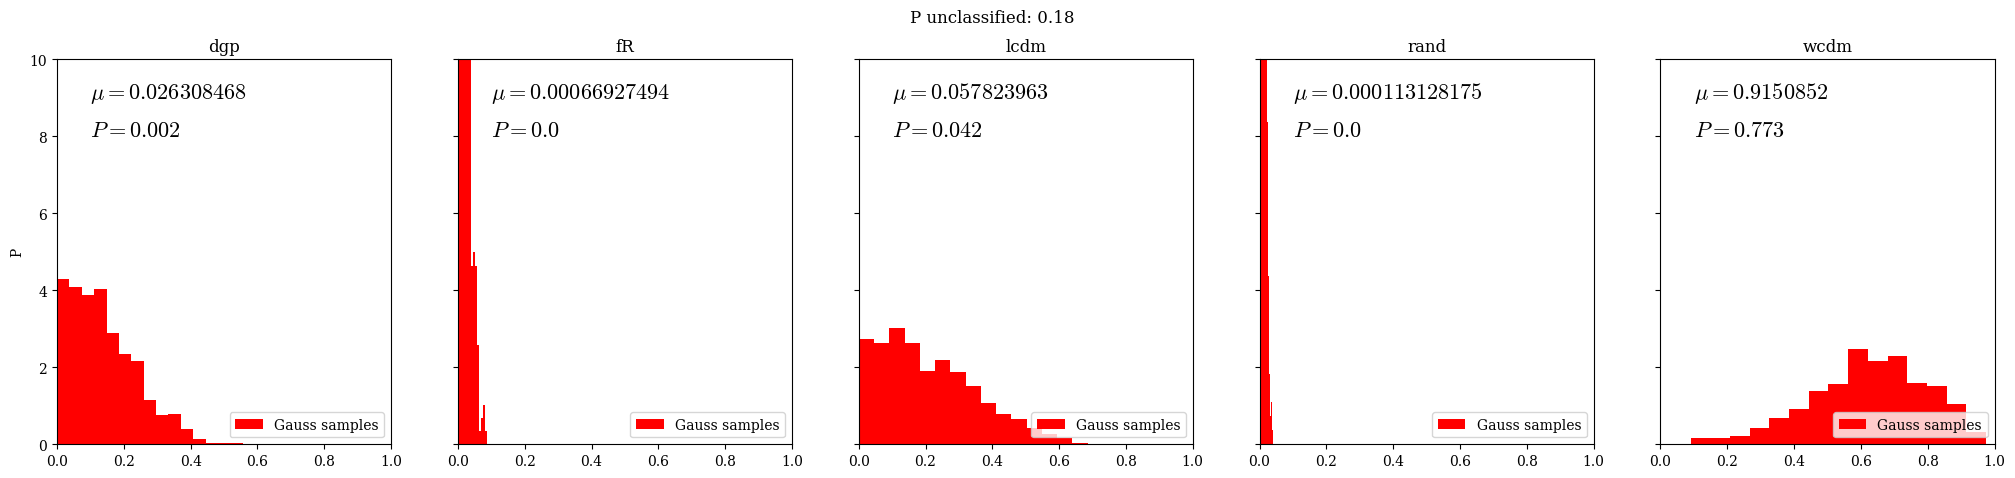

In [61]:
res_fR = get_all_probas(X_fR, 
                        model_5o, 
                        n_classes=5, 
                        num_monte_carlo=5, 
                        th_prob=0.5,
                        n_samples=1000)
print('P-non-LCDM=%s' %(np.delete(res_fR['P'], [2]).sum()))
plot_hist_1D(res_fR['samples'], 
             res_fR['MM'],
             th_prob=0.5,  
             P=res_fR['P'], 
             inv_labels_dict=inv_labels_dict_5)


## Loading and classifying custom spectra

Template for loading new spectra. Suppose you saved the spectrum in 
'data/example_spectra/my_ex.txt' . The spectrum is in 4 redshift bins and with 100 points between 0.01 - 2.5 in k . We normalize by the reference planck spectrum and add gaussian noise, then pass it to the five-label network.


In [62]:
my_k, my_X = load_X('data/planck.txt', 
                 sample_pace=None, i_max=None, 
                 norm_data=planck,
                 add_noise=True, normalise=True, use_sample_pace=False)

loaded data shape: (500, 5)
k, X  shape: (500,), (500, 4)
X  shape after sample pace:  (500, 4)
X  shape after k max: (500, 4)
planck data shape: (100, 4)


ValueError: operands could not be broadcast together with shapes (500,4) (100,4) 

In [ ]:
res_fR = get_all_probas(my_X, 
                        model_5, 
                        n_classes=5, 
                        num_monte_carlo=100, 
                        th_prob=0.5,
                        n_samples=10000)

Computing mu and sigma...


ValueError: in user code:

    File "/home/master/micromamba/envs/Bacon/lib/python3.9/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/home/master/micromamba/envs/Bacon/lib/python3.9/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/master/micromamba/envs/Bacon/lib/python3.9/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/home/master/micromamba/envs/Bacon/lib/python3.9/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/home/master/micromamba/envs/Bacon/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/master/micromamba/envs/Bacon/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_26" is incompatible with the layer: expected shape=(None, 100, 4), found shape=(None, 500, 4)
